In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import importlib
import nbimporter
import data_scraping
import data_cleaning
pd.options.display.min_rows = 20

In [2]:
importlib.reload(data_scraping)
importlib.reload(data_cleaning)

<module 'data_cleaning' from 'data_cleaning.ipynb'>

# 1. Scraping Data
We scrape the results of:

- Presidential elections for each state since 1789 to 2020

- Senator elections for each state from 1789 to 2020

- House representatives for each state from 1789 to 2022

- Governors for each state from 1789 to 2020, although this period range varies for each state depending on wether they held elections or not.

We use the module contained in scraping_module.py. This module is the exact same code than the jupyter notebook 01_scraping_data.ipynb

In the cell below, uncoment the two lines corresponding to each election that you would like.

In [3]:
## ------------- president elections
# file_name = 'presidential_by_state.csv'
# data_scraping.president_elections(file_name)

## ------------- senate elections
# file_name = 'senate_by_state.csv'
# data_scraping.senate_elections(file_name)

## ------------- house representatives elections
## Warning: takes a long time!
# file_name = 'house_by_state3.csv'
# data_scraping.house_elections(file_name)

## ------------- governor elections
# file_name = 'governor_by_state.csv'
# data_scraping.governor_elections(file_name)

# 2. Cleaning Data

We clean the data for each election, by removing unwanted strings, unwanted columns, etc. We use the module in clean_module.py, this module is the same as contained on the notebook 02_cleaning_data.ipynb. The notebook presents further information

In [4]:
path = '/Users/Angeles/Desktop/USA_elections/'

dfpi = pd.read_csv(path + 'presidential_by_state.csv')
dfp = data_cleaning.clean_president(dfpi)

dfsi = pd.read_csv(path + 'senators_by_state.csv')
dfs = data_cleaning.clean_senate(dfsi)

dfhi = pd.read_csv(path+'house_by_state.csv')
dfh = data_cleaning.clean_house(dfhi)

dfgi = pd.read_csv(path+'governors_by_state.csv')
dfg = data_cleaning.clean_governor(dfgi)

The House of Representatives has some States listed as "Error"


In [5]:
dfhi[dfhi['State']=='Error']

,Name,State,Term,Party
33782,"UNDERWOOD, Robert A.",Error,103rd Congress (1993-1995),Democrat
33783,"ROMERO-BARCELÓ, Carlos A.",Error,103rd Congress (1993-1995),Democrat
33784,"FALEOMAVAEGA, Eni F. H.",Error,103rd Congress (1993-1995),Democrat
33785,"DE LUGO, Ron",Error,103rd Congress (1993-1995),Democrat
36888,"FORTUÑO, Luis G.",Error,110th Congress (2007-2009),Republican
36889,"FALEOMAVAEGA, Eni F. H.",Error,110th Congress (2007-2009),Democrat
36890,"CHRISTENSEN, Donna Marie",Error,110th Congress (2007-2009),Democrat
36891,"BORDALLO, Madeleine",Error,110th Congress (2007-2009),Democrat
36959,"SABLAN, Gregorio Kilili Camacho",Error,111th Congress (2009-2011),Democrat
37340,"PIERLUISI, Pedro",Error,111th Congress (2009-2011),Democrat


## Unstacking and Merging the datasets

First, we need to change the shape of the dataframes. The Presidential, Senatorial and Guvernatorial elections have one elected candidate per year. Instead, the House of representative have multiple elected cancidates per year.

The image below shows the differnce between guvernatorial and house elections. 

Then, we change each table to have three columns "D", "R" and "O", for "democrat", 'republican', 'other'. In this way, we can count the number of elected people by year and party.

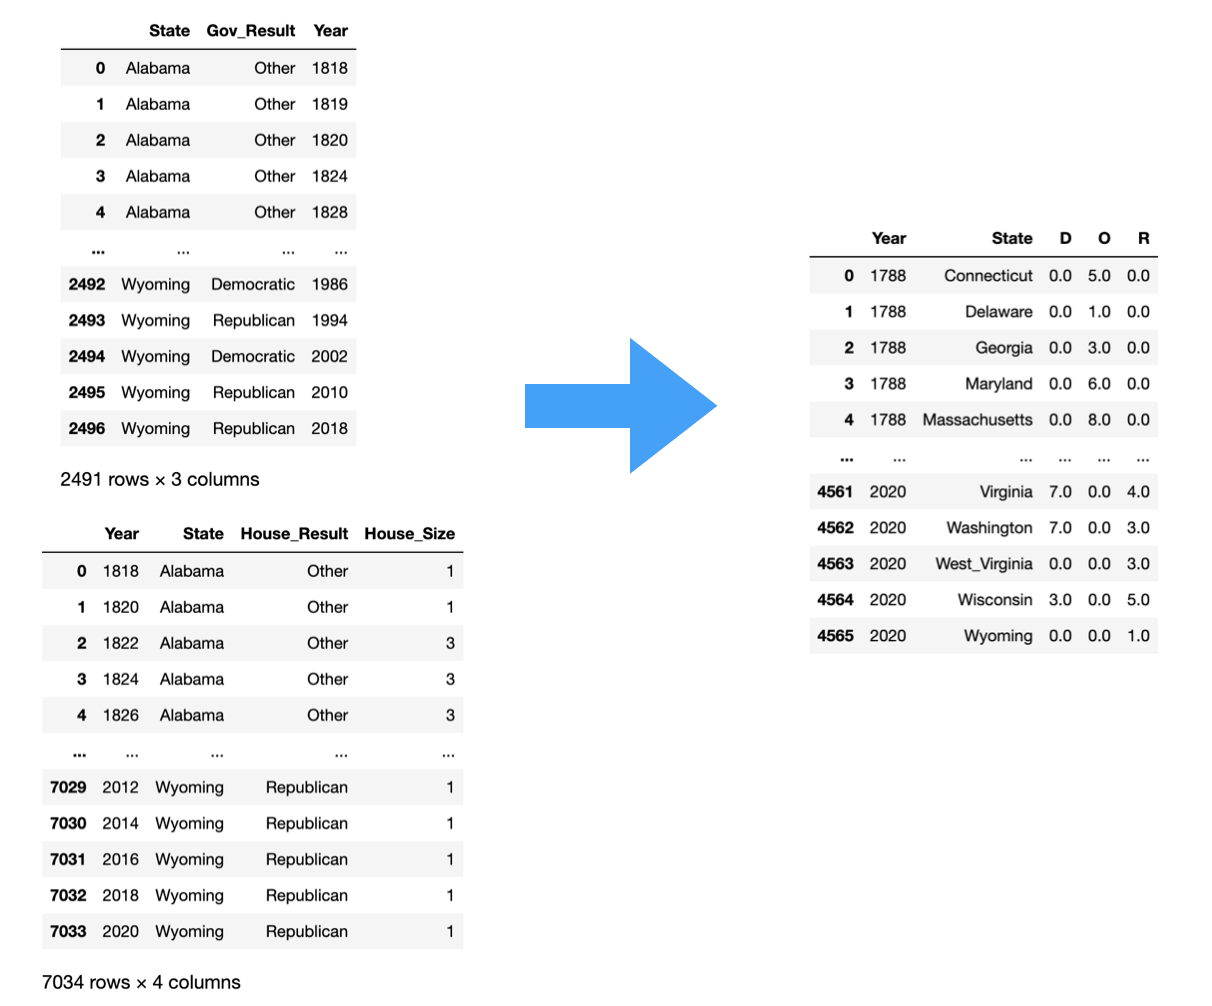

#### - Unstack House dataset

In [6]:
h_ustck = (dfh
    .set_index(['Year','State','House_Result'])
    .unstack('House_Result')
    .replace(np.nan, 0)
    .reset_index()
    .rename(columns={'Democratic':'D','Republican':'R','Other':'O'})
)

h_ustck.columns = h_ustck.columns.droplevel(level=0)
h_ustck.rename_axis(None,axis=1,inplace=True)
h_ustck.columns = ['Year','State','D','O','R']

#### - Unstack Senate, President and Governors

In [7]:
def new_columns(df, names):
    df.columns = names
    return(df)


def parties_unstack_count(df, branch, names):
    return(df.groupby(['State','Year', branch+'_Result'])
            .size()
            .to_frame(name = branch+'_Size') 
            .reset_index()
            .set_index(['Year','State',branch+'_Result'])
            .unstack(branch+'_Result')
            .replace(np.nan, 0)
            .reset_index()
            .pipe(new_columns, names) ## read WARNING for this line
            )
## WARNING!!!: check in which order are the columns returned from parties_unstack_count without the last pipe
## then you can assign the variable "names" in the correct order and activate that pipe

s_ustck = parties_unstack_count(dfs, branch='Sen', names=['Year','State','D','N','O','R'])
p_ustck = parties_unstack_count(dfp, branch='Presi', names=['Year','State','D','N','O','R'])
g_ustck = parties_unstack_count(dfg[['Year','State','Gov_Result']], branch='Gov', names=['Year','State','D','O','R'])

#### - Unstack and Merge President, Senator, Gobernor elections

In [8]:

dfgps = (dfg.set_index(['Year','State'])
       
       .merge(dfp.set_index(['Year','State'])
               , how='outer', on=['Year', 'State'],)
       .merge(dfs.set_index(['Year','State'])
                , how='outer', on=['Year', 'State'],)
       .reset_index()
       .drop_duplicates()
       .melt(id_vars=['Year','State'])
       .drop(columns=['variable'])
      )


dfgps ['D'] = dfgps.apply(lambda x: x.str.contains("Democratic").sum(), axis=1)
dfgps ['R'] = dfgps.apply(lambda x: x.str.contains("Republican").sum(), axis=1)
dfgps ['O'] = dfgps.apply(lambda x: x.str.contains("Other").sum(), axis=1)
dfgps ['NA'] = dfgps.apply(lambda x: x.str.contains("NaN").sum(), axis=1)

dfgps  = (dfgps.drop(columns=['value'])
          .groupby(['Year','State'])
          .sum()
          .reset_index()
          )

dfall = dfgps.set_index(['Year','State']).add(h_ustck.set_index(['Year','State']), fill_value=0).reset_index()

#### - Merge House with the rest

In [9]:
dfall = dfgps.set_index(['Year','State']).add(h_ustck.set_index(['Year','State']), fill_value=0).reset_index()

#### - Remove odd years
Since Senator, House and President elections are held on even years, we remove the odd years. When a governor is elected on and odd year, we move it to the closest even year

In [10]:
def remove_odd_yrs(df):
    m = df['Year']%2==0
    return (df
            .assign(Year = df['Year'].where(m, df['Year']-1))
            .groupby(['Year','State'])
            .sum()
            .reset_index()  
            )

In [11]:
# individual datasets
h_ustck =  remove_odd_yrs(h_ustck)
p_ustck =  remove_odd_yrs(p_ustck)
s_ustck =  remove_odd_yrs(s_ustck)
g_ustck =  remove_odd_yrs(g_ustck)
# merged dataset 
dfall =  remove_odd_yrs(dfall)

# 3. Data Analysis

## 3.1 Analysis of each goverment branch

#### 3.1.1 Time evolution of goverment branches

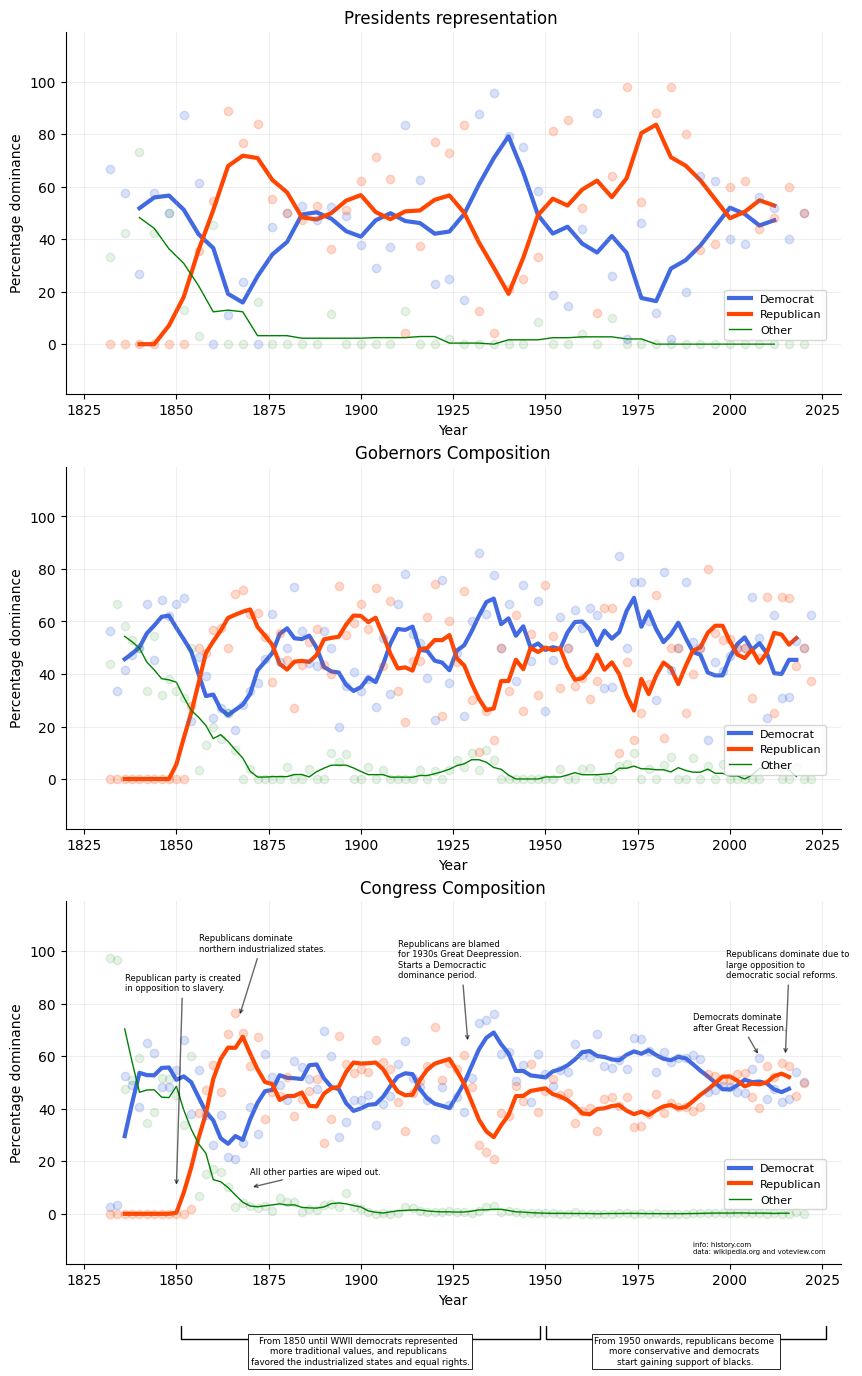

In [18]:
y0 = 1830





fig, axs = plt.subplots(3,1, figsize=(10,16))


##************************ presidential elections
ds = p_ustck[p_ustck['Year']>y0].groupby('Year').sum()['D']
rs = p_ustck[p_ustck['Year']>y0].groupby('Year').sum()['R']
os = p_ustck[p_ustck['Year']>y0].groupby('Year').sum()['O']
years = p_ustck[p_ustck['Year']>y0]['Year'].unique() #h_ustck[h_ustck['Year']>y0].groupby('State').mean()['Year']
pds = ds/(rs+ds+os)*100
prs = rs/(rs+ds+os)*100
pos = os/(rs+ds+os)*100
pdrm = pds.rolling(5,axis=0,center=True).mean()
prrm = prs.rolling(5,axis=0,center=True).mean()
porm = pos.rolling(5,axis=0,center=True).mean()
ii=0
axs[ii].scatter(years, pds, color='royalblue', alpha=0.2, zorder=2)
axs[ii].scatter(years, prs, color='orangered', alpha=0.2, zorder=2)
axs[ii].scatter(years, pos, color='green', alpha=0.1, zorder=2)
axs[ii].plot(pdrm,linewidth=3, color='royalblue',zorder=1,label='Democrat')
axs[ii].plot(prrm,linewidth=3,color='orangered',zorder=1,label='Republican')
axs[ii].plot(porm,linewidth=1,color='green',zorder=1,label='Other')
axs[ii].set_title('Presidents representation ')

##************************ congress: house and senate 
ds = s_ustck[s_ustck['Year']>y0].groupby('Year').sum()['D'] + h_ustck[h_ustck['Year']>y0].groupby('Year').sum()['D']
rs = s_ustck[s_ustck['Year']>y0].groupby('Year').sum()['R'] + h_ustck[h_ustck['Year']>y0].groupby('Year').sum()['R']
os = s_ustck[s_ustck['Year']>y0].groupby('Year').sum()['O'] + h_ustck[h_ustck['Year']>y0].groupby('Year').sum()['O']
years = s_ustck[s_ustck['Year']>y0]['Year'].unique() #h_ustck[h_ustck['Year']>y0].groupby('State').mean()['Year']
pds = ds/(rs+ds+os)*100
prs = rs/(rs+ds+os)*100
pos = os/(rs+ds+os)*100
pdrm = pds.rolling(5,axis=0,center=True).mean()
prrm = prs.rolling(5,axis=0,center=True).mean()
porm = pos.rolling(5,axis=0,center=True).mean()

ii=2
axs[ii].scatter(years, pds, color='royalblue', alpha=0.2, zorder=2)
axs[ii].scatter(years, prs, color='orangered', alpha=0.2, zorder=2)
axs[ii].scatter(years, pos, color='green', alpha=0.1, zorder=2)
axs[ii].plot(pdrm,linewidth=3, color='royalblue',zorder=1,label='Democrat')
axs[ii].plot(prrm,linewidth=3,color='orangered',zorder=1,label='Republican')
axs[ii].plot(porm,linewidth=1,color='green',zorder=1,label='Other')
axs[ii].set_title('Congress Composition')

##************************ governors
ds = g_ustck[g_ustck['Year']>y0].groupby('Year').sum()['D']
rs = g_ustck[g_ustck['Year']>y0].groupby('Year').sum()['R']
os = g_ustck[g_ustck['Year']>y0].groupby('Year').sum()['O']
years = g_ustck[g_ustck['Year']>y0]['Year'].unique() #h_ustck[h_ustck['Year']>y0].groupby('State').mean()['Year']
pds = ds/(rs+ds+os)*100
prs = rs/(rs+ds+os)*100
pos = os/(rs+ds+os)*100
pdrm = pds.rolling(5,axis=0,center=True).mean()
prrm = prs.rolling(5,axis=0,center=True).mean()
porm = pos.rolling(5,axis=0,center=True).mean()
ii=1
axs[ii].scatter(years, pds, color='royalblue', alpha=0.2, zorder=2)
axs[ii].scatter(years, prs, color='orangered', alpha=0.2, zorder=2)
axs[ii].scatter(years, pos, color='green', alpha=0.1, zorder=2)
axs[ii].plot(pdrm,linewidth=3, color='royalblue',zorder=1,label='Democrat')
axs[ii].plot(prrm,linewidth=3,color='orangered',zorder=1,label='Republican')
axs[ii].plot(porm,linewidth=1,color='green',zorder=1,label='Other')
axs[ii].set_title('Gobernors Composition')


for i in range(3):
    axs[i].grid(alpha=0.2)
    axs[i].set_ylabel('Percentage dominance')
    axs[i].set_xlabel('Year')
    axs[i].legend(loc=(0.85,0.15), fontsize=8)
    axs[i].set_ylim((-19,119))
    axs[i].set_xlim((1820,2030))
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

ia = 2    
axs[ia].annotate('Republican party is created\nin opposition to slavery.',xy=(1850,10), xytext=(1836,85),
             arrowprops=dict(facecolor='gray',arrowstyle='->',alpha=0.6),fontsize=6)

axs[ia].annotate('Republicans dominate \nnorthern industrialized states.',xy=(1867,75), xytext=(1856,100),
             arrowprops=dict(facecolor='gray',arrowstyle='->',alpha=0.6),fontsize=6)

axs[ia].annotate('Republicans are blamed \nfor 1930s Great Deepression. \nStarts a Democractic \ndominance period.',xy=(1929,65), xytext=(1910,90),
             arrowprops=dict(facecolor='gray',arrowstyle='->',alpha=0.6),fontsize=6)

axs[ia].annotate('All other parties are wiped out.',xy=(1870,10), xytext=(1870,15),
             arrowprops=dict(facecolor='gray',arrowstyle='->',alpha=0.6),fontsize=6)



axs[ia].annotate('Democrats dominate \nafter Great Recession.',xy=(2008,60), xytext=(1990,70),
             arrowprops=dict(facecolor='gray',arrowstyle='->',alpha=0.6),fontsize=6)

axs[ia].annotate('Republicans dominate due to \nlarge opposition to \ndemocratic social reforms.',xy=(2015,60), xytext=(1999,90),
             arrowprops=dict(facecolor='gray',arrowstyle='->',alpha=0.6),fontsize=6)



axs[ia].annotate('From 1850 until WWII democrats represented \nmore traditional values, and republicans \nfavored the industrialized states and equal rights.',
             xy=(0.38, -0.2), xytext=(0.38, -0.2), xycoords='axes fraction', 
            fontsize=3.5*1.8, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white',linewidth=0.6),
            arrowprops=dict(arrowstyle='-[, widthB=20.5, lengthB=1.5', lw=1.0))

axs[ia].annotate('From 1950 onwards, republicans become \nmore conservative and democrats \nstart gaining support of blacks.',
             xy=(0.8, -0.2), xytext=(0.8, -0.2), xycoords='axes fraction', 
            fontsize=3.5*1.8, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white',linewidth=0.6),
            arrowprops=dict(arrowstyle='-[, widthB=16.0, lengthB=1.5', lw=1.0))


axs[ia].annotate('info: history.com'+
             '\ndata: wikipedia.org and voteview.com',xy=(1990,-15), xytext=(1990,-15),
            fontsize=5)


fig.subplots_adjust(wspace=0.8)
fig.savefig('history.png',dpi=300)